In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [31]:
tester_results_dir = "Tester Results"

analyzer_results_dir = "Analyzer Results"

peakfinder_results_dir = "PeakFinder Results"

output_dir = "Plot Results"

In [32]:
os.makedirs(output_dir, exist_ok=True)

dfs = {}

for results_dir, prefix in [
    ("Tester Results", "TESTER"),
    ("Analyzer Results", "ANALYZER"),
    ("PeakFinder Results", "PEAKFINDER")
]:
    files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('RT') and not file.startswith('OVERVIEW')]
    for file in files:
        file_path = os.path.join(results_dir, file)
        key = f"{prefix}_{file.split('.')[0]}"
        dfs[key] = pd.read_excel(file_path)

print(list(dfs.keys()))
print(f"Loaded {len(dfs)} dataframes from all results directories.")

['TESTER_ALL_VAR_CORRELATIONS', 'TESTER_AVERAGED_RECORDER_EFFECTS', 'TESTER_AVG_EFFECT_STRENGTH_RECORDER_ACROSS_DATES', 'TESTER_COMPARE_TOPN_EFFECTS', 'TESTER_CORRELATIONS_BY_SEX_DATE', 'TESTER_EXPERIMENT_EFFECT_SIGNIFICANT_ONLY', 'TESTER_INTRATRIAL_DIFFERENCES', 'TESTER_INTRATRIAL_DIFFERENCES_SIGNIFICANT', 'TESTER_INTRATRIAL_DIFFERENCES_SUMMARY', 'TESTER_MERGED_EFFECT_STRENGTHS_TOP10_TOP20', 'TESTER_MERGED_EFFECT_STRENGTHS_TOP10_TOP20_MEANDIFF', 'TESTER_SIGNIFICANT_COUNT_RECORDER', 'TESTER_SIGNIFICANT_DATE_SPLIT', 'TESTER_SIGNIFICANT_RECORDER_COUNTS', 'TESTER_SIGNIFICANT_RECORDER_SPLIT', 'TESTER_SIGNIFICANT_SEX_SPLIT', 'TESTER_SIGNIFICANT_SEX_SPLIT_REACTION', 'TESTER_SIGNIFICANT_SEX_SPLIT_STRENGTH', 'TESTER_SIGNIFICANT_TOP20_SPLIT', 'TESTER_TEST_DATE', 'TESTER_TEST_DATE_MERGED_SEX', 'TESTER_TEST_EXPERIMENT_ALL_VARIABLES', 'TESTER_TEST_EXPERIMENT_ALL_VARIABLES_SIGNIFICANT', 'TESTER_TEST_EXPERIMENT_SEX_MERGED', 'TESTER_TEST_PEAKTIME_REACTIONTIME_TO_STRENGTH', 'TESTER_TEST_REC_ORDER', 'T

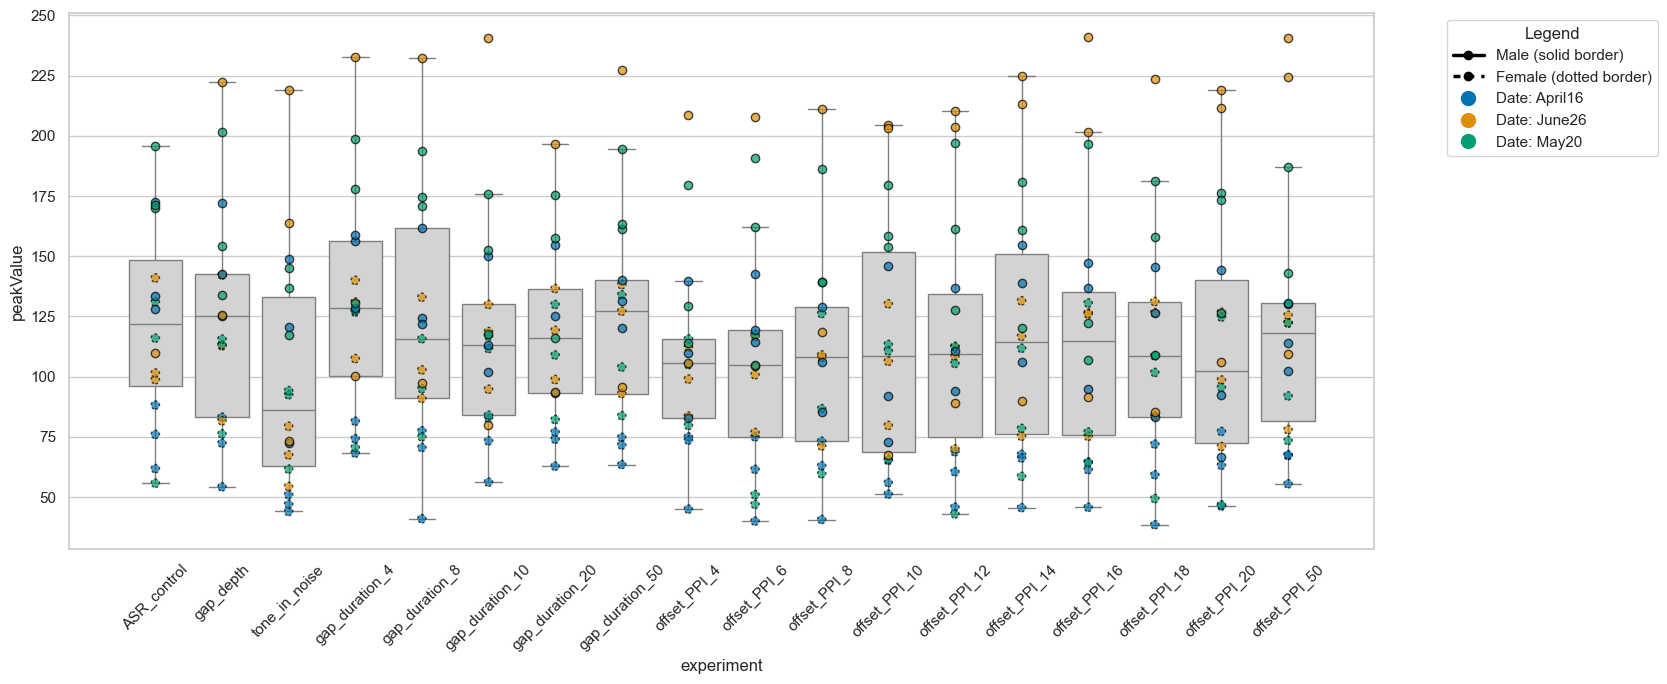

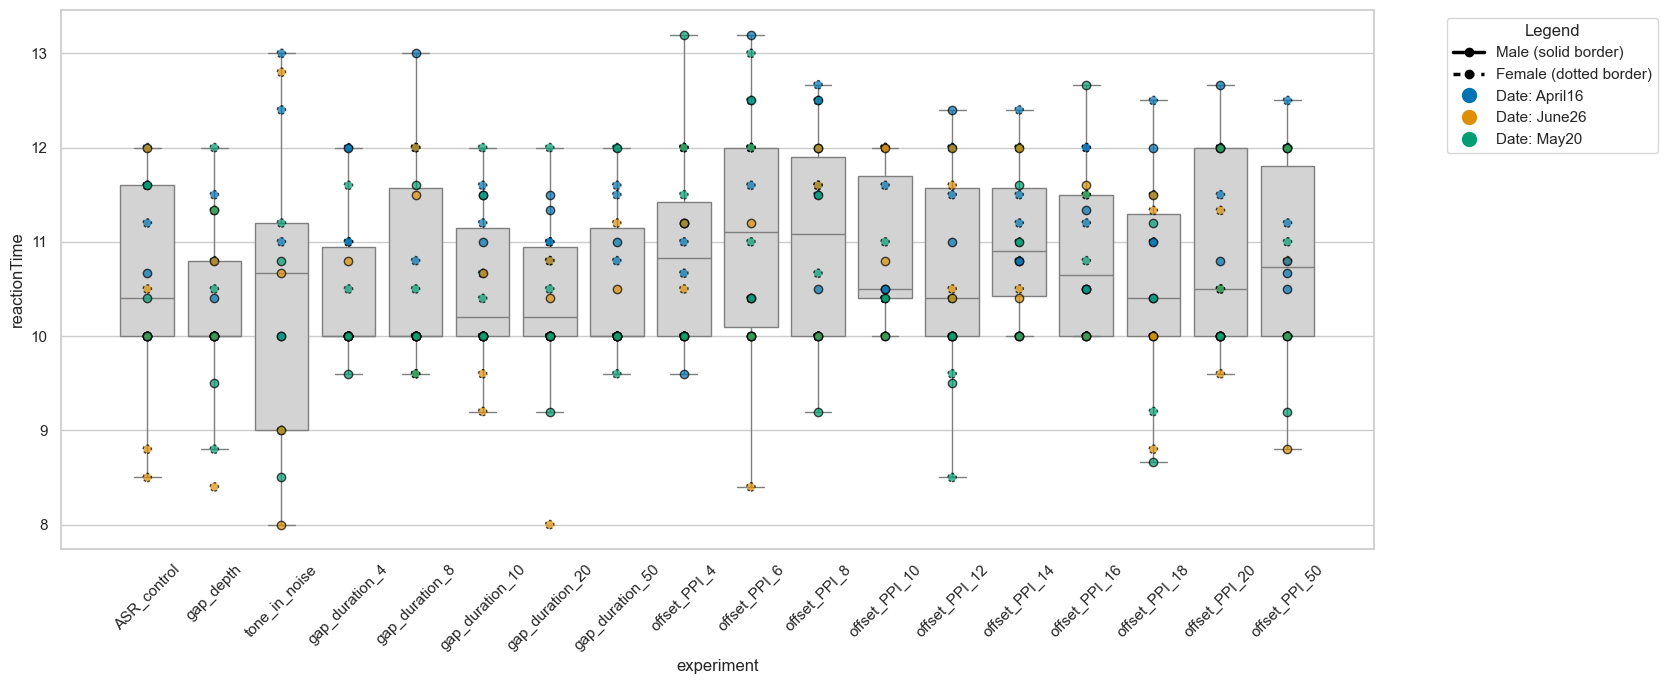

In [33]:
import matplotlib.lines as mlines

def get_dfs_key_for_df(df, dfs_dict):
    for key, obj in dfs_dict.items():
        if obj is df:
            return key
    return None

def plot_test_experiment(df_main, output_dir, variable='peakValue'):
    # Exclude extreme outliers (outside 1.5*IQR)
    Q1 = df_main[variable].quantile(0.25)
    Q3 = df_main[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_main = df_main[(df_main[variable] >= lower_bound) & (df_main[variable] <= upper_bound)]

    plt.figure(figsize=(14,7))
    # Boxplot
    sns.boxplot(data=df_main, x='experiment', y=variable, color='lightgray', showfliers=False, zorder=1)
    # Colorblind-friendly palette for dates
    unique_dates = sorted(df_main['date'].unique())
    palette = sns.color_palette("colorblind", n_colors=len(unique_dates))
    date_color_map = {date: palette[i] for i, date in enumerate(unique_dates)}
    # Scatterplot overlay, manual for border style
    linewidth_map = {'male': 1, 'female': 1}
    linestyle_map = {'male': 'solid', 'female': (0, (2, 2))}  # dotted for female

    for sex in df_main['sex'].unique():
        sub = df_main[df_main['sex'] == sex]
        for date in unique_dates:
            sub_date = sub[sub['date'] == date]
            color = date_color_map[date]  # Ensure each date gets its unique color
            for i, row in sub_date.iterrows():
                plt.scatter(
                    x=row['experiment'],
                    y=row[variable],
                    color=color,
                    edgecolors='black',
                    linewidths=linewidth_map[sex],
                    linestyle=linestyle_map[sex],
                    alpha=0.7,
                    marker='o',
                    zorder=2
                )
    df_key = get_dfs_key_for_df(df_main, dfs)

    """ # Fix: handle None case for df_key
    if df_key is not None and 'FIT' in df_key:
        plt.title(f'{variable} by Experiment (Scatter: Date Color, Sex Border Style; quantile fit)')
    else:
        plt.title(f'{variable} by Experiment (Scatter: Date Color, Sex Border Style)') """

    plt.ylabel(variable)
    plt.xlabel('experiment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'TEST_EXPERIMENT_{variable}_SCATTERBOX_{df_key}.png'))

    # Custom legend for sex border style
    male_handle = mlines.Line2D([], [], color='black', linestyle='solid', linewidth=2.5, marker='o', label='Male (solid border)')
    female_handle = mlines.Line2D([], [], color='black', linestyle=(0, (2,2)), linewidth=2.5, marker='o', label='Female (dotted border)')
    sex_legend = [male_handle, female_handle]

    # Custom legend for date colors
    date_handles = [
        mlines.Line2D([], [], color=date_color_map[date], marker='o', linestyle='None', markersize=10, label=f'Date: {date}')
        for date in unique_dates
    ]

    # Combine legends
    handles = sex_legend + date_handles
    plt.legend(handles=handles, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED'], output_dir, 'peakValue')
#plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED_FIT'], output_dir, 'peakValue')
plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED'], output_dir, 'reactionTime')
#plot_test_experiment(dfs['ANALYZER_RESULTS_MTT_MERGED_FIT'], output_dir, 'reactionTime')
# ...existing code...